#Team Members: 
Davide Baldelli -> davide.baldelli4@studio.unibo.it

Mohammad Reza Ghasemi Madani -> mohammadreza.ghasemi@studio.unibo.it

Mohammad Amin Nazerzadeh -> mohammad.nazerzadeh@studio.unibo.it

# Intro

In this assignment  we will ask you to perform POS tagging using neural architectures

You are asked to follow these steps:
*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the baseline model, choose hyperparameters using the validation set
*   Evaluate your two best model
*   Analyze the errors of your model


**Task**: given a corpus of documents, predict the POS tag for each word

**Corpus**:
Ignore the numeric value in the third column, use only the words/symbols and its label.
The corpus is available at:
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip

**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.


**Features**: you MUST use GloVe embeddings as the only input features to the model.

**Splitting**: you can decide to split documents into sentences or not, the choice is yours.

**I/O structure**: The input data will have three dimensions: 1-documents/sentences, 2-token, 3-features; for the output there are 2 possibilities: if you use one-hot encoding it will be 1-documents/sentences, 2-token labels, 3-classes, if you use a single integer that indicates the number of the class it will be 1-documents/sentences, 2-token labels.

**Baseline**: two layers architecture: a Bidirectional LSTM layer and a Dense/Fully-Connected layer on top; the choice of hyper-parameters is yours.

**Architectures**: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and adding an additional dense layer; do not mix these variantions.


**Training and Experiments**: all the experiments must involve only the training and validation sets.

**Evaluation**: in the end, only the two best models of your choice (according to the validation set) must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech. DO NOT CONSIDER THE PUNCTUATION CLASSES. [What is punctuation?]{https://en.wikipedia.org/wiki/English_punctuation}

**Metrics**: the metric you must use to evaluate your final model is the F1-macro, WITHOUT considering punctuation/symbols classes; during the training process you can use accuracy because you can't use the F1 metric unless you use a single (gigantic) batch because there is no way to aggregate "partial" F1 scores computed on mini-batches.

**Discussion and Error Analysis** : verify and discuss if the results on the test sets are coherent with those on the validation set; analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

**Report**: you are asked to deliver the code of your experiments and a small pdf report of about 2 pages; the pdf must begin with the names of the people of your team and a small abstract (4-5 lines) that sums up your findings.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd
from pprint import pprint
from google.colab import data_table
data_table.enable_dataframe_formatter()

## Reproducibility

Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds. Reproducibility is a fundamental evaluation property in order to make fair evaluation.
- Clear and reproducible data pipeline
- Model training and evaluation with multiple and fixed seeds

In [ ]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.use_deterministic_algorithms(True)

`torch.use_deterministic_algorithms` sets whether PyTorch operations must use “deterministic” algorithms. That is, algorithms which, given the same input, and when run on the same software and hardware, always produce the same output. When enabled, operations will use deterministic algorithms when available.

## Importing Data and Preprocessing

In [ ]:
!wget https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip
!unzip dependency_treebank.zip

--2023-01-06 12:00:30--  https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 457429 (447K) [application/zip]
Saving to: ‘dependency_treebank.zip’

dependency_treebank 100%[===================>] 446.71K  --.-KB/s    in 0.03s   

2023-01-06 12:00:30 (15.8 MB/s) - ‘dependency_treebank.zip’ saved [457429/457429]

Archive:  dependency_treebank.zip
   creating: dependency_treebank/
  inflating: dependency_treebank/wsj_0093.dp  
  inflating: dependency_treebank/wsj_0065.dp  
  inflating: dependency_treebank/wsj_0039.dp  
  inflating: dependency_treebank/wsj_0182.dp  
  inflating: dependency_treebank/wsj_0186.dp  
  inflating: dependency_treebank/wsj_0041.dp  
  inflating:

In [ ]:
# Generating the files names
file_names = ['dependency_treebank/' + fn for fn in os.listdir('dependency_treebank')]
file_names.sort()

def get_tuples(example):
    return tuple(example.split('\t')[:2])

def get_data(split):

  inputs = []
  outputs = []
  for fn in split:
    file = open(fn, 'r')
    list_row = file.read().split('\n')
    temp_inputs = []
    temp_outputs = []
    k = 0
    for i in range(len(list_row)):
      if list_row[i]=='':
        sentence = list(map(get_tuples, list_row[k:i]))
        x = [tpl[0] for tpl in sentence]
        y = [tpl[1] for tpl in sentence]
        temp_inputs.append(x)
        temp_outputs.append(y)
        k=i+1
    inputs.extend(temp_inputs)
    outputs.extend(temp_outputs)
  return pd.DataFrame({'sentence': inputs, 'tag': outputs})
  
# Seperate Train, Validation and Test set
train_fn = file_names[:100]
val_fn   = file_names[100:150]
test_fn  = file_names[150:]

train_split = get_data(train_fn)
val_split   = get_data(val_fn)
test_split  = get_data(test_fn)

print(f"Number of sentences in train split: {len(train_split)}")
print(f"Number of sentences in validation split: {len(val_split)}")
print(f"Number of sentences in validation split: {len(test_split)}")

Number of sentences in train split: 1963
Number of sentences in validation split: 1299
Number of sentences in validation split: 652


In [ ]:
print("Dataframe structure:")
train_split.describe(include='all')

Dataframe structure:


,sentence,tag
count,1963,1963
unique,1958,1949
top,"[Terms, were, n't, disclosed, .]","[NNS, VBD, RB, VBN, .]"
freq,5,5


In [ ]:
#Let's see how our structured and processed data looks like
print("Dataframe Head:")
train_split.head(10) 

Dataframe Head:


,sentence,tag
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."
5,"[Lorillard, Inc., ,, the, unit, of, New, York-...","[NNP, NNP, ,, DT, NN, IN, JJ, JJ, NNP, NNP, WD..."
6,"[Although, preliminary, findings, were, report...","[IN, JJ, NNS, VBD, VBN, RBR, IN, DT, NN, IN, ,..."
7,"[A, Lorillard, spokewoman, said, ,, ``, This, ...","[DT, NNP, NN, VBD, ,, ``, DT, VBZ, DT, JJ, NN, .]"
8,"[We, 're, talking, about, years, ago, before, ...","[PRP, VBP, VBG, IN, NNS, IN, IN, NN, VBD, IN, ..."
9,"[There, is, no, asbestos, in, our, products, n...","[EX, VBZ, DT, NN, IN, PRP$, NNS, RB, ., '']"


## GloVe Embedding

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. In this project, we use the GloVe variant with 6B tokens, 400K vocab, uncased, 50d vectors.

In [ ]:
import torch
import torch.nn as nn
from torchtext.vocab import GloVe

# We use GloVe with token size of 6B and embedding dimension size of 50
embedding_dim = 50
glove = GloVe(name = '6B', dim = embedding_dim)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|█████████▉| 399999/400000 [00:09<00:00, 41891.28it/s]


`GloVe` comes with:
- a dictionary `glove.stoi` associating each word in the GloVe vocabulary to an index;
- a list `glove.itos`, that is the GloVe vocabulary. For each word in the vocabulary, `glove.itos[ glove.stoi[word] ] = word`;
- a `torch.Tensor` `glove.vectors`, whose ith element is the GloVe embedding of the ith word in `glove.itos`. As a consequence, for each word, the embedding of the word can be retrieved with `glove.vectors[ glove.stoi[word] ]`.



## OOV Handling and Vectorization:

To handle Out Of Vocabulary (OOV) words we have opted for the placeholder approach ---> we embed the OOV words with vector of zeros.

In [ ]:
from copy import copy
from tqdm.notebook import tqdm_notebook

word2idx = copy(glove.stoi)
idx2word = copy(glove.itos)
embedding_vec_with_oov = copy(glove.vectors)

# Adding the padding token to the vocabulary
for word in word2idx:
  word2idx[word] += 1
word2idx['<pad>'] = 0
idx2word = ['<pad>'] + idx2word
embedding_vec_with_oov = torch.cat((torch.zeros(1,embedding_dim), embedding_vec_with_oov))


# Creating the vocabulary of words in the train datasets
train_vocab = []
for i, row in train_split.iterrows():
  sentence = row['sentence']
  for word in sentence:
      train_vocab.append(word)

# set of OOV1 words
oov1 = list(set(train_vocab).difference(set(idx2word)))

print("Extending the vocabulary with OOV1 words ...")
for word in tqdm_notebook(oov1):
  idx2word.append(word)
  embedding_vec_with_oov = torch.cat((embedding_vec_with_oov, torch.zeros(1,embedding_dim)))
  word2idx[word] = len(word2idx)


# Creating the vocabulary of words in the validation dataset
val_vocab = []
for i, row in val_split.iterrows():
  sentence = row['sentence']
  for word in sentence:
      val_vocab.append(word)

# set of OOV2 words
oov2 = list(set(val_vocab).difference(set(idx2word)))

print("Extending the vocabulary with OOV2 words ...")
for word in tqdm_notebook(oov2):
  idx2word.append(word)
  embedding_vec_with_oov = torch.cat((embedding_vec_with_oov, torch.zeros(1,embedding_dim)))
  word2idx[word] = len(word2idx)

  
# Creating the vocabulary of words in the test datasets
test_vocab = []
for i, row in test_split.iterrows():
  sentence = row['sentence']
  for word in sentence:
      test_vocab.append(word)

# set of OOV3 words
oov3 = list(set(test_vocab).difference(set(idx2word)))

print("Extending the vocabulary with OOV3 words ...")
for word in tqdm_notebook(oov3):
  idx2word.append(word)
  embedding_vec_with_oov = torch.cat((embedding_vec_with_oov, torch.zeros(1,50)))
  word2idx[word] = len(word2idx)

Extending the vocabulary with OOV1 words ...


  0%|          | 0/2346 [00:00<?, ?it/s]

Extending the vocabulary with OOV2 words ...


  0%|          | 0/944 [00:00<?, ?it/s]

Extending the vocabulary with OOV3 words ...


  0%|          | 0/455 [00:00<?, ?it/s]

In [ ]:
print(
    f'Number of OOVs in ...\n'
    f'Train set ----------------------------------------------- {len(oov1)}\n'
    f'Validation set ------------------------------------------ {len(oov2)}\n'
    f'Test set ------------------------------------------------ {len(oov3)}'
)

Number of OOVs in ...
Train set ----------------------------------------------- 2346
Validation set ------------------------------------------ 944
Test set ------------------------------------------------ 455


In [ ]:
print(
    f'Glove vocab size ---------------------------------------- {len(glove.stoi)}\n'
    f'Golve + Train OOV --------------------------------------- {len(glove.stoi) + len(oov1)}\n'
    f'Glove + Train + Validation OOV -------------------------- {len(glove.stoi) + len(oov1) + len(oov2)}\n'
    f'Glove + Train + Validation + Test OOV ------------------- {len(glove.stoi) + len(oov1) + len(oov2) + len(oov3)}\n'
    f'Glove + Train + Validation + Test OOV + <pad> token ----- {len(glove.stoi) + len(oov1) + len(oov2) + len(oov3) + 1}\n'
)

Glove vocab size ---------------------------------------- 400000
Golve + Train OOV --------------------------------------- 402346
Glove + Train + Validation OOV -------------------------- 403290
Glove + Train + Validation + Test OOV ------------------- 403745
Glove + Train + Validation + Test OOV + <pad> token ----- 403746



## Tags
#### Tags Vocabularization:

In [ ]:
# 'Vocabulary' of tags
ind2tag, ind = np.unique(['<pad>'] + [tag for sentence in train_split['tag'] for tag in sentence], return_index=True)
ind2tag = ind2tag[np.argsort(ind)]
tag2idx = {tag:idx for (idx, tag) in enumerate(ind2tag)}
print(f"number of different tags in the training set: {len(tag2idx)}")

number of different tags in the training set: 46


We check if there are tags which exist in the validation set, but not in the training set:


In [ ]:
ind2tag_val = np.unique([tag for sentence in val_split['tag'] for tag in sentence])
ind2tag_test = np.unique([tag for sentence in test_split['tag'] for tag in sentence])

val_train_tag_diff = list(set(ind2tag_val).difference(set(ind2tag)))

print(f"Tags in Validation/Train set: {val_train_tag_diff}")

Tags in Validation/Train set: []


We will continue with the assumption of universality and completeness of the tags which are available in the train set

#### Tags Distributions

Let's have a look to the distribution of the tags.

In [ ]:
train_tag_list = [tag for sentence in train_split['tag'] for tag in sentence if tag!='<pad>']
validation_tag_list = [tag for sentence in val_split['tag'] for tag in sentence if tag!='<pad>']

Note:
- To sort the table, click on the column you wish as sorting parameter (e.g. count)

In [ ]:
from collections import Counter

train_tag_df = pd.DataFrame({'tag':Counter(train_tag_list).keys(), 'count':Counter(train_tag_list).values()})
train_tag_df.head(50)

# to sort the following table select the 'count' in the header

,tag,count
0,NNP,5202
1,",",2571
2,CD,1439
3,NNS,3004
4,JJ,2992
5,MD,413
6,VB,1195
7,DT,4076
8,NN,6270
9,IN,4952


Here we can see the most frequent tags that are `NN`, `NNP`, `IN`, and so on. Now we will see the same thing in the validation set

In [ ]:
validation_tag_df = pd.DataFrame({'tag':Counter(validation_tag_list).keys(), 'count':Counter(validation_tag_list).values()})
validation_tag_df.head(50)

,tag,count
0,DT,2754
1,NNP,2704
2,NN,4513
3,VBD,861
4,JJ,1924
5,NNS,2102
6,IN,3275
7,JJR,165
8,$,173
9,CD,1249


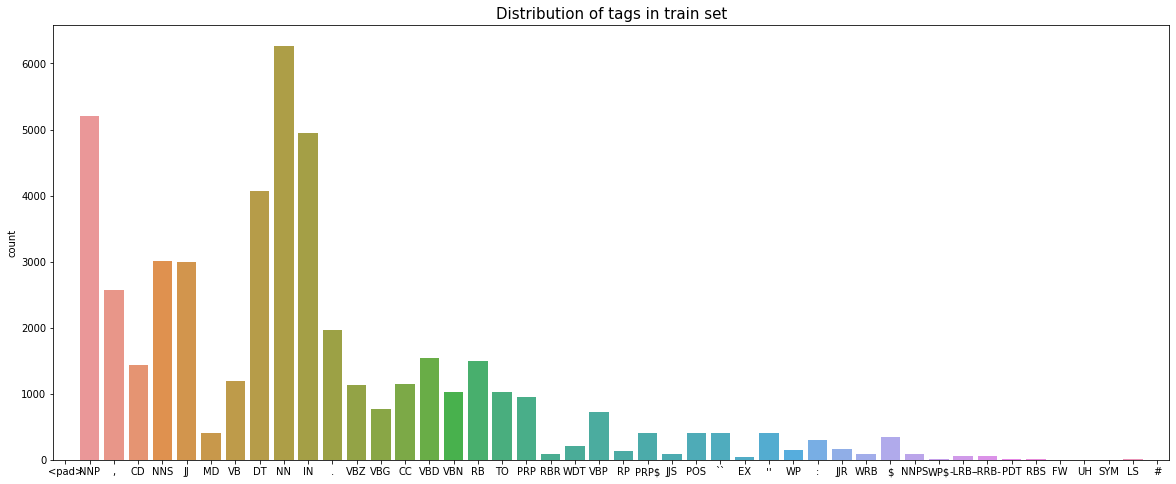

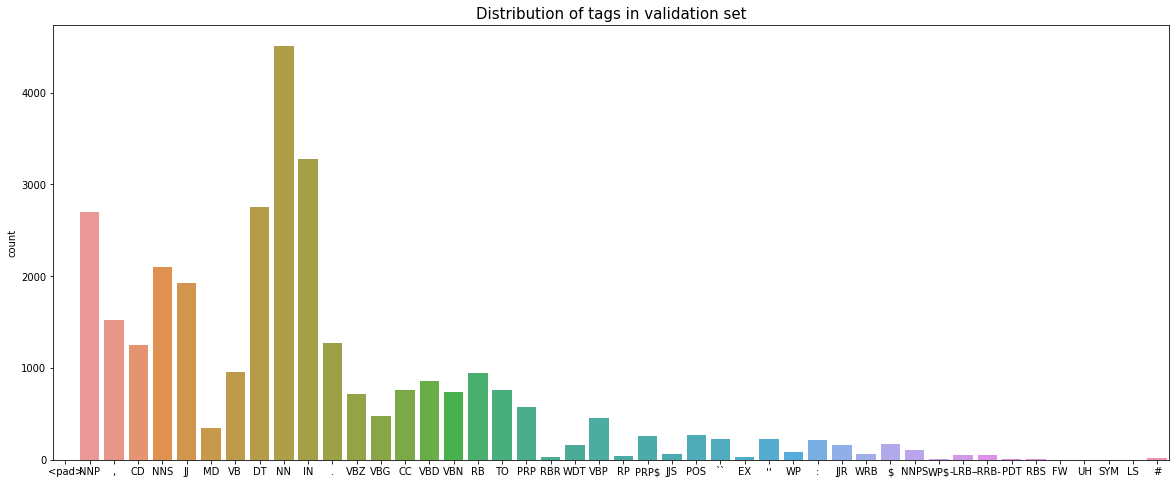

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,8))
sns.countplot(x = train_tag_list, order=ind2tag)
plt.title('Distribution of tags in train set', size = 15)
plt.show()

plt.figure(figsize=(20,8))
sns.countplot(x = validation_tag_list, order=ind2tag)
plt.title('Distribution of tags in validation set', size = 15)
plt.show()


We can see that the tags' distribution in both train and validation sets are almost similar. Now we can extract the features from the datasets by vectorizing the words and tags in the sequences.

#### Vectorization
Now we vectorize the sequences (sentences and tags) in the train, validation, and test set. But first, we have to consider the puctuation and remove them for validation and test set.

#### Handling Puctuations
As we discussed in the beginning we have to ignore the puntuation when evaluating the test and the validation set. First we get the punctuation indexes so we can ignore them at evaluation time.

In [ ]:
print(f'Tags list with {len(tag2idx)} unique tags is:\n')
print(ind2tag)

Tags list with 46 unique tags is:

['<pad>' 'NNP' ',' 'CD' 'NNS' 'JJ' 'MD' 'VB' 'DT' 'NN' 'IN' '.' 'VBZ'
 'VBG' 'CC' 'VBD' 'VBN' 'RB' 'TO' 'PRP' 'RBR' 'WDT' 'VBP' 'RP' 'PRP$'
 'JJS' 'POS' '``' 'EX' "''" 'WP' ':' 'JJR' 'WRB' '$' 'NNPS' 'WP$' '-LRB-'
 '-RRB-' 'PDT' 'RBS' 'FW' 'UH' 'SYM' 'LS' '#']


In [ ]:
import string
punct = list(string.punctuation)

print('List of Enlish punctuatios\n')
print(punct)

List of Enlish punctuatios

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


There are two other symbols (" \`  ` " and " ' ' ") that are in the tag list but not in the puctuation list and are irrelevant when we want to evaluate the results. We simply add them manually and ignore them during the evaluation.

In [ ]:
punct = punct + ['``',"''"]

In [ ]:
ignore_indices = []
for i, tag in enumerate(ind2tag):
  if tag in punct:
    ignore_indices.append(i)

print('Indices of the puctuations in the tags\' list are:', ignore_indices)

Indices of the puctuations in the tags' list are: [2, 11, 27, 29, 31, 34, 45]


We set the extracted punctuation and symbols indices to 0 so we can ignore them in evaluation phase by setting `ignore_index` attribute of the loss function to 0.

In [ ]:
# vectorization
def seq_vec(seq):
  return [word2idx[word] for word in seq]

def tag_vec(tags):
  return [tag2idx[tag] for tag in tags]

# we use this function for vaildation and test set to assign 0 to the puncts and symbols
def tag_vec_ignore_punct(tags):
  return [tag2idx[tag] if  tag not in punct else 0 for tag in tags]


X_train = list(map(seq_vec, train_split['sentence']))
y_train = list(map(tag_vec, train_split['tag']))

X_val = list(map(seq_vec, val_split['sentence']))
y_val = list(map(tag_vec_ignore_punct, val_split['tag']))

X_test = list(map(seq_vec, test_split['sentence']))
y_test = list(map(tag_vec_ignore_punct, test_split['tag']))

The vectorized data looks like the following:

In [ ]:
temp = pd.DataFrame({'Sentence':train_split['sentence'], 'Vectorized Sentence':X_train})
temp.head()

,Sentence,Vectorized Sentence
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[400519, 401535, 2, 4979, 83, 168, 2, 44, 1430..."
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[401844, 401535, 15, 664, 4, 400448, 401338, 2..."
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[400548, 401235, 2, 3069, 83, 168, 6, 158, 664..."
3,"[A, form, of, asbestos, once, used, to, make, ...","[400946, 684, 4, 14666, 443, 181, 5, 160, 4015..."
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[401255, 14666, 7677, 2, 401159, 2, 15, 7683, ..."


In [ ]:
temp = pd.DataFrame({'Sentence':train_split['tag'], 'Vectorized Sentence':y_train})
temp.head()

,Sentence,Vectorized Sentence
0,"[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...","[1, 1, 2, 3, 4, 5, 2, 6, 7, 8, 9, 10, 8, 5, 9,..."
1,"[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...","[1, 1, 12, 9, 10, 1, 1, 2, 8, 1, 13, 9, 11]"
2,"[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...","[1, 1, 2, 3, 4, 5, 14, 5, 9, 10, 1, 1, 1, 1, 2..."
3,"[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...","[8, 9, 10, 9, 17, 16, 18, 7, 1, 9, 4, 12, 16, ..."
4,"[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...","[8, 9, 9, 2, 9, 2, 12, 17, 5, 10, 19, 12, 8, 4..."


We use this vectorized sequences as the model's input. Each number in the sequence refers to a word in out vocabulary which can be obtained from `idx2word` or `ind2tag` lists.  

## Padding Strategy

To pass the data to our models, both the sentences and the tags must have a fixed length. To do so, we have to pad those sequences with `<pad>` token or truncate them to a fixed length. To find a compromise between padding and truncation, we will have a look at the distribution of the lengths of the sentences. 


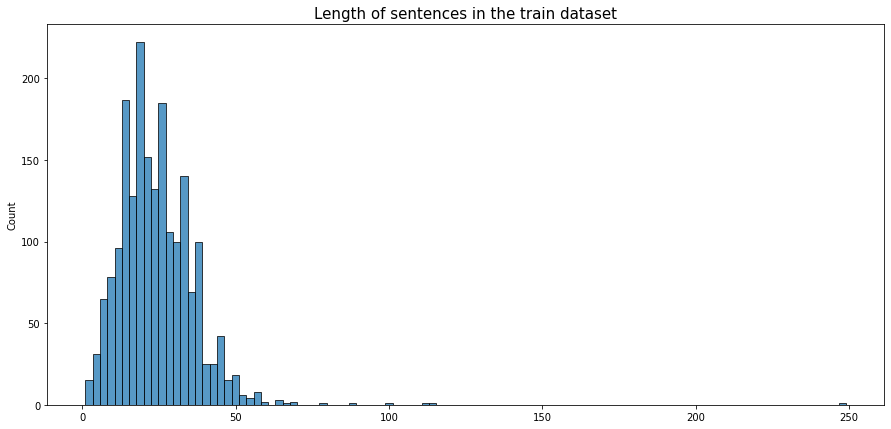


Percentage of sentences less long than 50 words:  0.9801324503311258


In [ ]:
# Pad or Truncate each sentence to max_seq_length

import matplotlib.pyplot as plt
import seaborn as sns

length_of_sentences = np.array([len(sentence) for sentence in train_split['sentence']])

plt.figure(figsize = (15,7))
sns.histplot(length_of_sentences)
plt.title('Length of sentences in the train dataset', size = 15)
plt.show()

print("\nPercentage of sentences less long than 50 words: ", np.sum(length_of_sentences<50)/len(length_of_sentences))

It seems that setting the maximum allowed length to $50$ is a good design choice. Although, it may be inefficient to pad all the sequences to a fixed length. For example, if the length of sequences in a size $8$ batch is $[4,6,8,5,4,3,7,8]$, we will pad all the sequences and that will result in 8 sequences of length $8$ and end up doing $64$ computations $(8*8)$ when training RNN (LSTM, GRU, and etc.). However, we need to do only $45$ computations. This even gets worse, if we use a bidirectional-RNN and do batch computations just by padding.

Instead, PyTorch  allows to pack the sequence, internally using `collate_fn` in the `DataLoader` which represents a Python iterable over a dataset. Basically, the `collate_fn` receives a list of tuples if your `__getitem__` function from a Dataset subclass returns a tuple, or just a normal list if your Dataset subclass returns only one element. Here, its main objective is to create batch of padded sequences without spending much time implementing it manually. 

We define `collate_fn` such that packed sequence is a triple of lists. One contains the elements of sequences and others contain sequence labels and the size of each sequence in the batch at each step. This is helpful in recovering the actual sequences as well as telling RNN what is the batch size at each time step.

We use PyTorch `pack_padded_sequence` which packs a Tensor containing padded sequences of variable length. Finally we use `pad_packed_sequence` that is an inverse operation to `pack_padded_sequence` to unpack the sequences so we can generate the output.

In [ ]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

def pad_collate_fn(batch):
    """
    The collate_fn that can add padding to the sequences so all can have
    the same length as the longest one.

    Args:
        batch (List[List, List]): The batch data, where the first element
        of the tuple is the word idx and the second element are the target
        label.

    Returns:
        A triple (x, y, z). The element x is a tensor of packed sequence .
        The element y is a tensor of padded tag indices. The word vectors are
        padded with vectors of 0s and the tag indices are padded with 0s. z is the lengths of original sequences in the input
    """

    # This gets us two lists of tensors and a list of integer.
    # Each tensor in the first list is a sequence of word vectors.
    # Each tensor in the second list is a sequence of tag indices.
    # The list of integer consist of the lengths of the sequences in order.
    sequences_vectors, sequences_labels, lengths = zip(
        *[
            (torch.IntTensor(seq_vectors), torch.LongTensor(labels), len(seq_vectors))
            for (seq_vectors, labels) in sorted(
                batch, key=lambda x: len(x[0]), reverse=True
            )
        ]
    )

    lengths = torch.LongTensor(lengths)

    padded_sequences_vectors = pad_sequence(
        sequences_vectors, batch_first=True, padding_value=0
    )

    padded_sequences_labels = pad_sequence(
        sequences_labels, batch_first=True, padding_value=0
    )

    # return pack_padded_sequences_vectors, padded_sequences_labels
    return padded_sequences_vectors, padded_sequences_labels, lengths

Finally, we can create the DataLoaders for training , validation, and testing the model

In [ ]:
class DatasetBucket:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


Note:
- Choosing a `batch_size` can be critical. By choosing a big `batch_size` we may include long sequences (e.g. with len 50) together with short (e.g. with len 4) which will result in inefficient padding. While, with an approperiate `batch_size` the variaton of the lengths is much smaller and the padding would be more efficient.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

train_dataset = DatasetBucket(X_train, y_train)
train_dl = DataLoader(train_dataset, batch_size=batch_size, collate_fn= pad_collate_fn, num_workers=2)

val_dataset = DatasetBucket(X_val, y_val)
val_dl = DataLoader(val_dataset, batch_size=batch_size, collate_fn= pad_collate_fn, num_workers=2)

test_dataset = DatasetBucket(X_test, y_test)
test_dl = DataLoader(test_dataset, batch_size=batch_size, collate_fn= pad_collate_fn, num_workers=2)

We can see in the following that how this approach pad the sequences dynamically in each batch

In [ ]:
it = iter(train_dl)
print('First 10 Batch Shapes\n')
for i in range(10):
    batch = next(it)
    print(f'Batch_{i}: ', batch[0].shape)


First 10 Batch Shapes

Batch_0:  torch.Size([32, 52])
Batch_1:  torch.Size([32, 37])
Batch_2:  torch.Size([32, 39])
Batch_3:  torch.Size([32, 54])
Batch_4:  torch.Size([32, 46])
Batch_5:  torch.Size([32, 46])
Batch_6:  torch.Size([32, 58])
Batch_7:  torch.Size([32, 48])
Batch_8:  torch.Size([32, 49])
Batch_9:  torch.Size([32, 40])


In [ ]:
it = iter(train_dl)
print('Max/Min Sequences\' Length in First 10 Batch \n')
for i in range(10):
    batch = next(it)
    print(f'Batch_{i} --> Max:{batch[2][0]} - Min: {batch[2][-1]} ')

Max/Min Sequences' Length in First 10 Batch 

Batch_0 --> Max:52 - Min: 10 
Batch_1 --> Max:37 - Min: 10 
Batch_2 --> Max:39 - Min: 4 
Batch_3 --> Max:54 - Min: 5 
Batch_4 --> Max:46 - Min: 12 
Batch_5 --> Max:46 - Min: 9 
Batch_6 --> Max:58 - Min: 6 
Batch_7 --> Max:48 - Min: 7 
Batch_8 --> Max:49 - Min: 9 
Batch_9 --> Max:40 - Min: 7 


we can see that overally, padded sequences have less length than the ones with fixed length padding strategy

## Models Architecture
We now implement the baseline architecture and make simple and small modification to generate other variances based on this baseline model

## Baseline Model

Baseline model is a sequence of Embedding layer, LSTM layer, and Time-distributed Dense layer

In [ ]:
from torch.nn.modules import dropout
from torch.nn import LSTM, Embedding, GRU
from torch.nn.utils.rnn import pad_packed_sequence

# Size of the hidden vector of LSTM/GRU cells
hidden_size = 32  

class RnnLangModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        # Defining embeddings as a layer in the model 
        self.embedding = Embedding(num_embeddings=len(word2idx), embedding_dim=embedding_dim)  
        # Freezing the embedding layer in order not to be trainable
        self.embedding.from_pretrained(embedding_vec_with_oov, freeze = True)       
        self.lstm = LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True, bidirectional= True)   
        # Time Distributed Linear Layer
        self.tdl = nn.Conv2d(1, len(tag2idx), (1, hidden_size * 2))  
        self.dropout = nn.Dropout(0.25)

    def forward(self, input, lengths):
        embedded_padded_input = self.embedding(input)
        # We pack the padded sequence to improve the computational speed during training
        embedded_packed_padded_input = pack_padded_sequence(embedded_padded_input, lengths, batch_first=True)  
        output, (ht, ct) = self.lstm(embedded_packed_padded_input)
        # Unpacking the packed padded output
        output, _ = pad_packed_sequence(output, batch_first=True) 
        return self.tdl(self.dropout(torch.unsqueeze(output, dim = 1)))


rnn_lm = RnnLangModel(hidden_size = hidden_size)

We take a look at the structure of the output

In [ ]:
# Batch_size * Num_tags * Seq_len * 1
it = iter(train_dl)
batch = next(it)

# Model output for a single batch 
rnn_lm(batch[0], batch[2]).shape

torch.Size([32, 46, 52, 1])

### Modified Model No. 1
using a GRU instead of the LSTM in the baseline model.

The GRU is the newer generation of Recurrent Neural networks and is pretty similar to an LSTM. GRU’s got rid of the cell state and used the hidden state to transfer information. It also only has two gates, a reset gate and update gate. Here are the main points comparing the two:

- The GRU unit controls the flow of information like the LSTM unit, but without having to use a memory unit. It just exposes the full hidden content without any control.

- GRUs are relatively new, and their performance is on par with LSTMs, but computationally more efficient (they have a less complex structure).

In [ ]:
from torch.nn import LSTM, Embedding, GRU

class GruLangModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.embedding = Embedding(num_embeddings=len(word2idx), embedding_dim=embedding_dim)
        # embedding_dim = 50
        self.embedding.from_pretrained(embedding_vec_with_oov, freeze = True) 
        self.gru = GRU(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True, bidirectional= True) 
        # Time Distributed Linear Layer 
        self.tdl = nn.Conv2d(1, len(tag2idx), (1, hidden_size * 2))   
        self.dropout = nn.Dropout(0.25)                                                 

    def forward(self, input, lengths):
        embedded_padded_input = self.embedding(input)
        # We pack the padded sequence to improve the computational speed during training
        embedded_packed_padded_input = pack_padded_sequence(embedded_padded_input, lengths, batch_first=True)  
        output, (ht, ct) = self.gru(embedded_packed_padded_input)
        # Unpacking the packed padded output
        output, _ = pad_packed_sequence(output, batch_first=True) 
        return self.tdl(self.dropout(torch.unsqueeze(output, dim = 1)))


gru_lm = GruLangModel(hidden_size = hidden_size)

### Modified Model No. 2
adding an additional LSTM layer

In [ ]:
from torch.nn import LSTM, Embedding, GRU

class LstmLangModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        # Defining embeddings as a layer in the model 
        self.embedding = Embedding(num_embeddings=len(word2idx), embedding_dim=embedding_dim)  
        # Freezing the embedding layer in order not to be trainable
        self.embedding.from_pretrained(embedding_vec_with_oov, freeze = True)       
        self.lstm = LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=2, dropout=0.25, batch_first=True, bidirectional= True)   
        # Time Distributed Linear Layer
        self.tdl = nn.Conv2d(1, len(tag2idx), (1, hidden_size * 2))  
        self.dropout = nn.Dropout(0.25)

    def forward(self, input, lengths):
        embedded_padded_input = self.embedding(input)
        # We pack the padded sequence to improve the computational speed during training
        embedded_packed_padded_input = pack_padded_sequence(embedded_padded_input, lengths, batch_first=True)  
        output, (ht, ct) = self.lstm(embedded_packed_padded_input)
        # Unpacking the packed padded output
        output, _ = pad_packed_sequence(output, batch_first=True) 
        return self.tdl(self.dropout(torch.unsqueeze(output, dim = 1)))


lstm_lm = LstmLangModel(hidden_size = hidden_size)

### Modified Model No. 3
adding an additional dense layer

In [ ]:
from torch.nn import LSTM, Embedding, GRU, Linear

class DenseLangModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        # Defining embeddings as a layer in the model 
        self.embedding = Embedding(num_embeddings=len(word2idx), embedding_dim=embedding_dim)  
        # Freezing the embedding layer in order not to be trainable
        self.embedding.from_pretrained(embedding_vec_with_oov, freeze = True)       
        self.lstm = LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True, bidirectional= True) 
        # Fully connected Linear Layer  
        self.dense  = Linear(hidden_size * 2, hidden_size * 2)
        self.dense2 = Linear(hidden_size * 2, len(tag2idx))
        self.relu = nn.ReLU()

    def forward(self, input, lengths):
        embedded_padded_input = self.embedding(input)
        # We pack the padded sequence to improve the computational speed during training
        embedded_packed_padded_input = pack_padded_sequence(embedded_padded_input, lengths, batch_first=True)  
        output, (ht, ct) = self.lstm(embedded_packed_padded_input)
        # # Unpacking the packed padded output
        output, _ = pad_packed_sequence(output, batch_first=True) 
        output = self.dense(output)
        output = self.dense2(output)
        # We have to reformat the output structure to be the same as other models
        return torch.unsqueeze(torch.permute(output, (0,2,1)), -1)        


dense_lm = DenseLangModel(hidden_size = hidden_size)

### Train

We will use `CrossEntropyLoss` as loss function to train our models. Also `F1Score` (with Macro average) has been utilize as a metric when we evaluate the trained model.

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 13.7 MB/s eta 0:00:00


Note:
- During the training we do not ignore puctuations and symbols since they may be useful. For evaluation we ignore the puctuations and symbols. In the train set, only `<pad>` token has the index equal to 0 but in the validation and test set, puctuations and symbols index are also set to 0 so we can ignore them using `ignore_index`.

In [ ]:
from torch.nn import CrossEntropyLoss
from torchmetrics import Accuracy, F1Score, Precision, Recall

# During the training we do not ignore puctuations and symbols since they may be useful
ce_loss = CrossEntropyLoss(reduction='mean', ignore_index=0)
f1_score = F1Score(task="multiclass", average="macro", num_classes=len(tag2idx), ignore_index=0)
accuracy = Accuracy(task="multiclass", num_classes=len(tag2idx), ignore_index=0)

#### Training 

In [ ]:
# Training Loop
from torch import optim
from tqdm import tqdm

# model, model_name = rnn_lm, 'lstm_lm'
model, model_name  = gru_lm, 'gru_lm'
# model, model_name  = lstm_lm, 'multilstm_lm'
# model, model_name  = dense_lm, 'multidense_lm'


optimizer = optim.Adam(model.parameters())

best_val_loss = None
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []
train_f1_list, val_f1_list = [], []

for epoch in range(50):
    running_loss = 0.0
    p_list, y_list = [], []
    print(f'Epoch {epoch+1}')
    for i, (seqs, tags, lens) in enumerate(tqdm(train_dl)):
        optimizer.zero_grad()

        preds = model(seqs, lens).squeeze(dim = -1)
        loss = ce_loss(preds, tags)
        loss.backward()
        optimizer.step()

        # saving the outputs of the model in a list for analysis
        p_list += torch.argmax(preds, dim=1).flatten().tolist()
        y_list += tags.flatten().tolist()

        running_loss += loss.item()

    
    p_list = torch.tensor(p_list)
    y_list = torch.tensor(y_list)
    
    # computing the epoch metrics
    train_loss = running_loss / len(train_dl)
    train_acc_value = accuracy(p_list, y_list).item()
    train_f1_value = f1_score(p_list, y_list).item()

    # saving the metrics for visualization
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc_value)
    train_f1_list.append(train_f1_value)

    print(f'Loss: {train_loss:.4f}')
    print('Running evaluation ...')
    
    running_loss = 0.0
    p_list, y_list = [], []
    with torch.inference_mode():
        model.eval()
        for (seqs, tags, lens) in tqdm(val_dl):
            preds = model(seqs, lens).squeeze(dim = -1)
            loss = ce_loss(preds, tags)

            # saving the outputs of the model in a list for analysis
            p_list += torch.argmax(preds, dim=1).flatten().tolist()
            y_list += tags.flatten().tolist()

            running_loss += loss.item()

        p_list = torch.tensor(p_list)
        y_list = torch.tensor(y_list)

        # calculating validation metrics at each epoch
        val_loss = running_loss / len(val_dl)
        val_acc_value = accuracy(p_list, y_list).item()
        val_f1_value = f1_score(p_list, y_list).item()
        
        # saving the metrics for visualization
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc_value)
        val_f1_list.append(val_f1_value)

        # saving the best weights based on validation loss
        if best_val_loss is None or val_loss < best_val_loss:
            print(f'Saving new checkpoint ...')
            print(f'Best ---> Val_Loss: {val_loss:.4f}, F1_Score: {val_f1_value:.4f}, Accuracy: {val_acc_value:.4f}')
            torch.save({'model_state_dict': model.state_dict()}, f'./{model_name}')
            best_val_loss = val_loss

        print('------------------')




Epoch 1


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


Loss: 3.2555
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.25it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 2.6860, F1_Score: 0.0524, Accuracy: 0.2836
------------------
Epoch 2


100%|██████████| 62/62 [00:16<00:00,  3.66it/s]


Loss: 2.1914
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 82.41it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 2.1244, F1_Score: 0.1350, Accuracy: 0.4273
------------------
Epoch 3


100%|██████████| 62/62 [00:16<00:00,  3.65it/s]


Loss: 1.7228
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 81.41it/s]


Saving new checkpoint ...
Best ---> Val_Loss: 1.8065, F1_Score: 0.2104, Accuracy: 0.5008
------------------
Epoch 4


100%|██████████| 62/62 [00:16<00:00,  3.65it/s]


Loss: 1.4555
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 88.97it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 1.5957, F1_Score: 0.2652, Accuracy: 0.5536
------------------
Epoch 5


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


Loss: 1.2686
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 86.03it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 1.4403, F1_Score: 0.2894, Accuracy: 0.5911
------------------
Epoch 6


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


Loss: 1.1222
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 82.50it/s]


Saving new checkpoint ...
Best ---> Val_Loss: 1.3179, F1_Score: 0.3340, Accuracy: 0.6260
------------------
Epoch 7


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


Loss: 1.0005
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 79.13it/s]


Saving new checkpoint ...
Best ---> Val_Loss: 1.2176, F1_Score: 0.3693, Accuracy: 0.6556
------------------
Epoch 8


100%|██████████| 62/62 [00:16<00:00,  3.69it/s]


Loss: 0.8958
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 86.50it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 1.1338, F1_Score: 0.4003, Accuracy: 0.6785
------------------
Epoch 9


100%|██████████| 62/62 [00:16<00:00,  3.67it/s]


Loss: 0.8041
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 86.27it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 1.0630, F1_Score: 0.4340, Accuracy: 0.6996
------------------
Epoch 10


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


Loss: 0.7231
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.01it/s]


Saving new checkpoint ...
Best ---> Val_Loss: 1.0029, F1_Score: 0.4584, Accuracy: 0.7174
------------------
Epoch 11


100%|██████████| 62/62 [00:16<00:00,  3.68it/s]


Loss: 0.6513
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.86it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.9517, F1_Score: 0.4735, Accuracy: 0.7319
------------------
Epoch 12


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


Loss: 0.5876
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 42.39it/s]


Saving new checkpoint ...
Best ---> Val_Loss: 0.9082, F1_Score: 0.4875, Accuracy: 0.7463
------------------
Epoch 13


100%|██████████| 62/62 [00:16<00:00,  3.65it/s]


Loss: 0.5311
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.43it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.8713, F1_Score: 0.4991, Accuracy: 0.7589
------------------
Epoch 14


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


Loss: 0.4810
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.76it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.8400, F1_Score: 0.5087, Accuracy: 0.7691
------------------
Epoch 15


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


Loss: 0.4365
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 87.54it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.8135, F1_Score: 0.5175, Accuracy: 0.7774
------------------
Epoch 16


100%|██████████| 62/62 [00:16<00:00,  3.70it/s]


Loss: 0.3968
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.38it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7911, F1_Score: 0.5240, Accuracy: 0.7853
------------------
Epoch 17


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


Loss: 0.3612
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 86.79it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7723, F1_Score: 0.5295, Accuracy: 0.7926
------------------
Epoch 18


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


Loss: 0.3294
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 86.15it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7566, F1_Score: 0.5344, Accuracy: 0.7980
------------------
Epoch 19


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


Loss: 0.3008
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.72it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7436, F1_Score: 0.5369, Accuracy: 0.8027
------------------
Epoch 20


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


Loss: 0.2750
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.98it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7330, F1_Score: 0.5401, Accuracy: 0.8072
------------------
Epoch 21


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


Loss: 0.2517
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.49it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7244, F1_Score: 0.5427, Accuracy: 0.8107
------------------
Epoch 22


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


Loss: 0.2307
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 90.36it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7175, F1_Score: 0.5482, Accuracy: 0.8138
------------------
Epoch 23


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


Loss: 0.2117
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 88.98it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7122, F1_Score: 0.5510, Accuracy: 0.8167
------------------
Epoch 24


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


Loss: 0.1944
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.58it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7082, F1_Score: 0.5628, Accuracy: 0.8193
------------------
Epoch 25


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


Loss: 0.1788
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.61it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7053, F1_Score: 0.5652, Accuracy: 0.8220
------------------
Epoch 26


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


Loss: 0.1645
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 87.95it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7034, F1_Score: 0.5725, Accuracy: 0.8239
------------------
Epoch 27


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


Loss: 0.1515
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 89.20it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7023, F1_Score: 0.5772, Accuracy: 0.8257
------------------
Epoch 28


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


Loss: 0.1397
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 87.98it/s] 


Saving new checkpoint ...
Best ---> Val_Loss: 0.7020, F1_Score: 0.5773, Accuracy: 0.8266
------------------
Epoch 29


100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


Loss: 0.1289
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 86.69it/s] 


------------------
Epoch 30


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


Loss: 0.1190
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 87.85it/s] 


------------------
Epoch 31


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


Loss: 0.1100
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 80.69it/s]


------------------
Epoch 32


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


Loss: 0.1017
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 86.07it/s] 


------------------
Epoch 33


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


Loss: 0.0941
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.42it/s] 


------------------
Epoch 34


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


Loss: 0.0872
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 86.03it/s] 


------------------
Epoch 35


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


Loss: 0.0808
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 88.73it/s] 


------------------
Epoch 36


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


Loss: 0.0749
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 84.97it/s] 


------------------
Epoch 37


100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


Loss: 0.0695
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 86.49it/s] 


------------------
Epoch 38


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


Loss: 0.0646
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 86.71it/s] 


------------------
Epoch 39


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


Loss: 0.0600
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 87.27it/s] 


------------------
Epoch 40


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


Loss: 0.0558
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 88.74it/s] 


------------------
Epoch 41


100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


Loss: 0.0520
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 82.97it/s]


------------------
Epoch 42


100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


Loss: 0.0485
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.98it/s] 


------------------
Epoch 43


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


Loss: 0.0452
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 82.03it/s]


------------------
Epoch 44


100%|██████████| 62/62 [00:16<00:00,  3.71it/s]


Loss: 0.0422
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.62it/s] 


------------------
Epoch 45


100%|██████████| 62/62 [00:17<00:00,  3.49it/s]


Loss: 0.0394
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 84.43it/s] 


------------------
Epoch 46


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


Loss: 0.0369
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 87.57it/s] 


------------------
Epoch 47


100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


Loss: 0.0345
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.59it/s] 


------------------
Epoch 48


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


Loss: 0.0323
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.66it/s] 


------------------
Epoch 49


100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


Loss: 0.0302
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 85.13it/s] 


------------------
Epoch 50


100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


Loss: 0.0283
Running evaluation ...


100%|██████████| 41/41 [00:00<00:00, 86.85it/s] 


------------------


#### Test Evaluation
We now load the best weight to the model and get the outputs for those wieghts to analyse the error and further properties.

In [ ]:
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
from torchmetrics import Accuracy, F1Score


def evaluate(model, data_loader):
    running_loss = 0.0
    p_list, y_list = [], []
    with torch.inference_mode():
        model.eval()
        for (seqs, tags, lens) in tqdm(data_loader):
            preds = model(seqs, lens).squeeze(dim = -1)
            loss = ce_loss(preds, tags)

            # saving the outputs of the model in a list for analysis
            p_list += torch.argmax(preds, dim=1).flatten().tolist()
            y_list += tags.flatten().tolist()

            running_loss += loss.item()

        p_list = torch.tensor(p_list)
        y_list = torch.tensor(y_list)

        # computing test set metrics based on the best wieght
        test_loss = running_loss / len(data_loader)
        test_f1_value = f1_score(p_list, y_list).item()
        test_acc_value = accuracy(p_list, y_list).item()

    return test_loss, test_f1_value, test_acc_value
    

# Loading the best weights of the training
print(f'Loading checkpoint ...')
checkpoint = torch.load(f'./{model_name}')
model.load_state_dict(checkpoint['model_state_dict'])

print('Running evaluation ...')
test_loss, test_f1_value, test_acc_value = evaluate(model, test_dl)

print('\nTest Metrics\n----------------')
print(f'Val_Loss: {test_loss:.4f}')
print(f'Accuracy: {test_acc_value:.4f}')
print(f'F1_Score: {test_f1_value:.4f}')

Loading checkpoint ...
Running evaluation ...


100%|██████████| 21/21 [00:00<00:00, 38.07it/s]



Test Metrics
----------------
Val_Loss: 0.6450
Accuracy: 0.8323
F1_Score: 0.5653


In [ ]:
# saving the results for future use (plotting and etc.)
import pickle

stats = {
    'train':{
        'cross_entropy':train_loss_list,
        'f1_score':train_f1_list,
        'accuracy':train_acc_list
    },
    'validation':{
        'cross_entropy':val_loss_list,
        'f1_score':val_f1_list,
        'accuracy':val_acc_list
    },
    'test':{
        'cross_entropy':test_loss,
        'f1_score':test_f1_value,
        'accuracy':test_acc_value
    }
}

# saving stats as .pkl file
with open(f'{model_name}_stats.pickle', 'wb') as p:
    pickle.dump(stats, p, protocol=pickle.HIGHEST_PROTOCOL)

## Results Comparison


In [ ]:
# creating structure for dataframe
results = {
    'lstm_lm':{
        'loss':None,
        'f1_score':None,
        'accuracy':None
    },
    'gru_lm':{
        'loss':None,
        'f1_score':None,
        'accuracy':None
    },
    'multilstm_lm':{
        'loss':None,
        'f1_score':None,
        'accuracy':None
        },
    'multidense_lm':{
        'loss':None,
        'f1_score':None,
        'accuracy':None
        },
}

#### Validation Set

In [ ]:
models = [rnn_lm, gru_lm, lstm_lm, dense_lm]
models_names = ['lstm_lm', 'gru_lm', 'multilstm_lm', 'multidense_lm']


for model, name in zip(models, models_names):
    print(f'Loading checkpoint for {name} ...')
    checkpoint = torch.load(f'./{name}')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    loss_value, f1_value, acc_value = evaluate(model, val_dl)


    results[name]['loss'] = loss_value
    results[name]['f1_score'] = f1_value
    results[name]['accuracy'] = acc_value

pd.DataFrame(results).T.head()

Loading checkpoint for lstm_lm ...


100%|██████████| 41/41 [00:00<00:00, 76.87it/s]


Loading checkpoint for gru_lm ...


100%|██████████| 41/41 [00:01<00:00, 36.93it/s]


Loading checkpoint for multilstm_lm ...


100%|██████████| 41/41 [00:01<00:00, 30.93it/s]


Loading checkpoint for multidense_lm ...


100%|██████████| 41/41 [00:01<00:00, 37.12it/s]


,loss,f1_score,accuracy
lstm_lm,0.664042,0.573960,0.829803
gru_lm,0.701986,0.577291,0.826605
multilstm_lm,0.742455,0.523077,0.809963
multidense_lm,0.794033,0.517503,0.797318


#### Test Set

In [ ]:
models = [rnn_lm, gru_lm, lstm_lm, dense_lm]
models_names = ['lstm_lm', 'gru_lm', 'multilstm_lm', 'multidense_lm']


for model, name in zip(models, models_names):
    print(f'Loading checkpoint for {name} ...')
    checkpoint = torch.load(f'./{name}')
    model.load_state_dict(checkpoint['model_state_dict'])
    
    loss_value, f1_value, acc_value = evaluate(model, test_dl)


    results[name]['loss'] = loss_value
    results[name]['f1_score'] = f1_value
    results[name]['accuracy'] = acc_value

pd.DataFrame(results).T.head()

Loading checkpoint for lstm_lm ...


100%|██████████| 21/21 [00:00<00:00, 64.95it/s]


Loading checkpoint for gru_lm ...


100%|██████████| 21/21 [00:00<00:00, 64.16it/s]


Loading checkpoint for multilstm_lm ...


100%|██████████| 21/21 [00:00<00:00, 53.72it/s]


Loading checkpoint for multidense_lm ...


100%|██████████| 21/21 [00:00<00:00, 63.73it/s]


,loss,f1_score,accuracy
lstm_lm,0.608241,0.564370,0.837442
gru_lm,0.645044,0.565277,0.832337
multilstm_lm,0.693171,0.534716,0.818188
multidense_lm,0.738426,0.517146,0.805718


Based on the result we can see on the tables above, it seems the best model `Accuracy` and `F1-Macro` seems to be the one with GRU layer and although the performance of the other top models is almost similar, we choose this model to analyze the outputs and errors.

### Display model performance for Best Model (GRU)

We show the stats for each single tag using `classification_report`. Then we analyse the results for each tag and reason about the causes of errors in that group.

### model performance

In [ ]:
best_model, model_name = rnn_lm, 'lstm_lm'

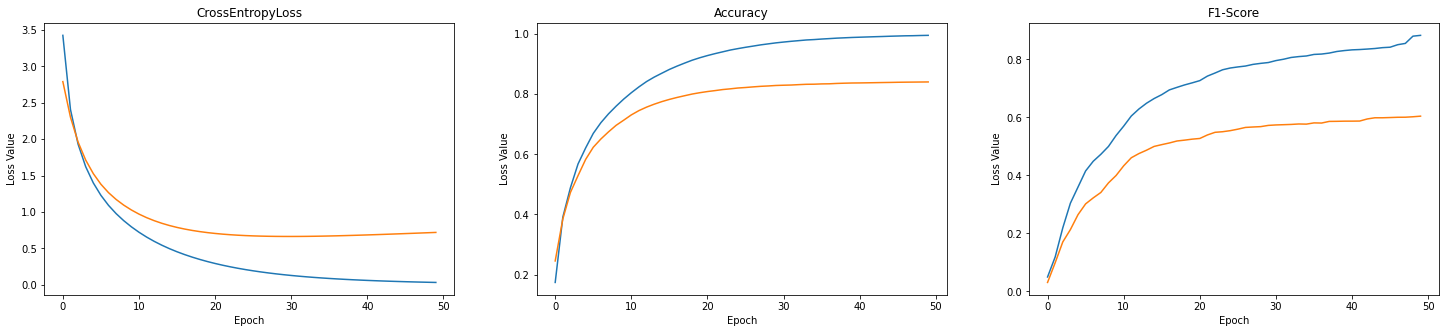

In [ ]:
def plot_stats(model_stats):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (25,5))

    ax1.plot(stats['train']['cross_entropy'])
    ax1.plot(stats['validation']['cross_entropy'])
    ax1.set_title('CrossEntropyLoss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss Value')

    ax2.plot(stats['train']['accuracy'])
    ax2.plot(stats['validation']['accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss Value')

    ax3.plot(stats['train']['f1_score'])
    ax3.plot(stats['validation']['f1_score'])
    ax3.set_title('F1-Score')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss Value')



# saving stats as .pkl file
with open(f'{model_name}_stats.pickle', 'rb') as p:
    stats = pickle.load(p)

plot_stats(stats)

In [ ]:
print(f'Loading checkpoint for {model_name} ...')
checkpoint = torch.load(f'./{model_name}')
best_model.load_state_dict(checkpoint['model_state_dict'])

p_list, y_list = [], []
with torch.inference_mode():
    best_model.eval()
    for (seqs, tags, lens) in tqdm(test_dl):
        preds = model(seqs, lens).squeeze(dim = -1)

        # saving the outputs of the model in a list for analysis
        p_list += torch.argmax(preds, dim=1).flatten().tolist()
        y_list += tags.flatten().tolist()

    p_list = torch.tensor(p_list)
    y_list = torch.tensor(y_list)

Loading checkpoint for lstm_lm ...


100%|██████████| 21/21 [00:00<00:00, 51.97it/s]


Note:
- To sort the table, click on the column you wish as sorting parameter (e.g. f1-score)

In [ ]:
from sklearn.metrics import classification_report

report_test = classification_report(y_list, p_list, output_dict=True)
report_df = pd.DataFrame.from_dict(report_test).drop(columns=['accuracy', 'macro avg', 'weighted avg'])
report_df = report_df.T.round(decimals=2)
report_df.head(50)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

,precision,recall,f1-score,support
0,0.00,0.00,0.00,15624.0
1,0.79,0.66,0.72,1504.0
2,0.00,0.00,0.00,0.0
3,0.87,0.77,0.82,858.0
4,0.67,0.71,0.69,941.0
5,0.59,0.69,0.64,918.0
6,0.95,0.96,0.96,167.0
7,0.78,0.85,0.81,403.0
8,0.97,0.99,0.98,1335.0
9,0.76,0.81,0.78,2383.0


Not considering `<pad>` (index 0) and puctuation tags (refer to `ignore_indices` or just consider this list: 2, 11, 27, 29, 31, 34, 45) that are at the top of the list, the best model has very poor performance on some other tasks which we have discussed the possible causes in the main report.

In [ ]:
# worst tags
ind2tag[35], ind2tag[36], ind2tag[39], ind2tag[17]

('NNPS', 'WP$', 'PDT', 'RB')

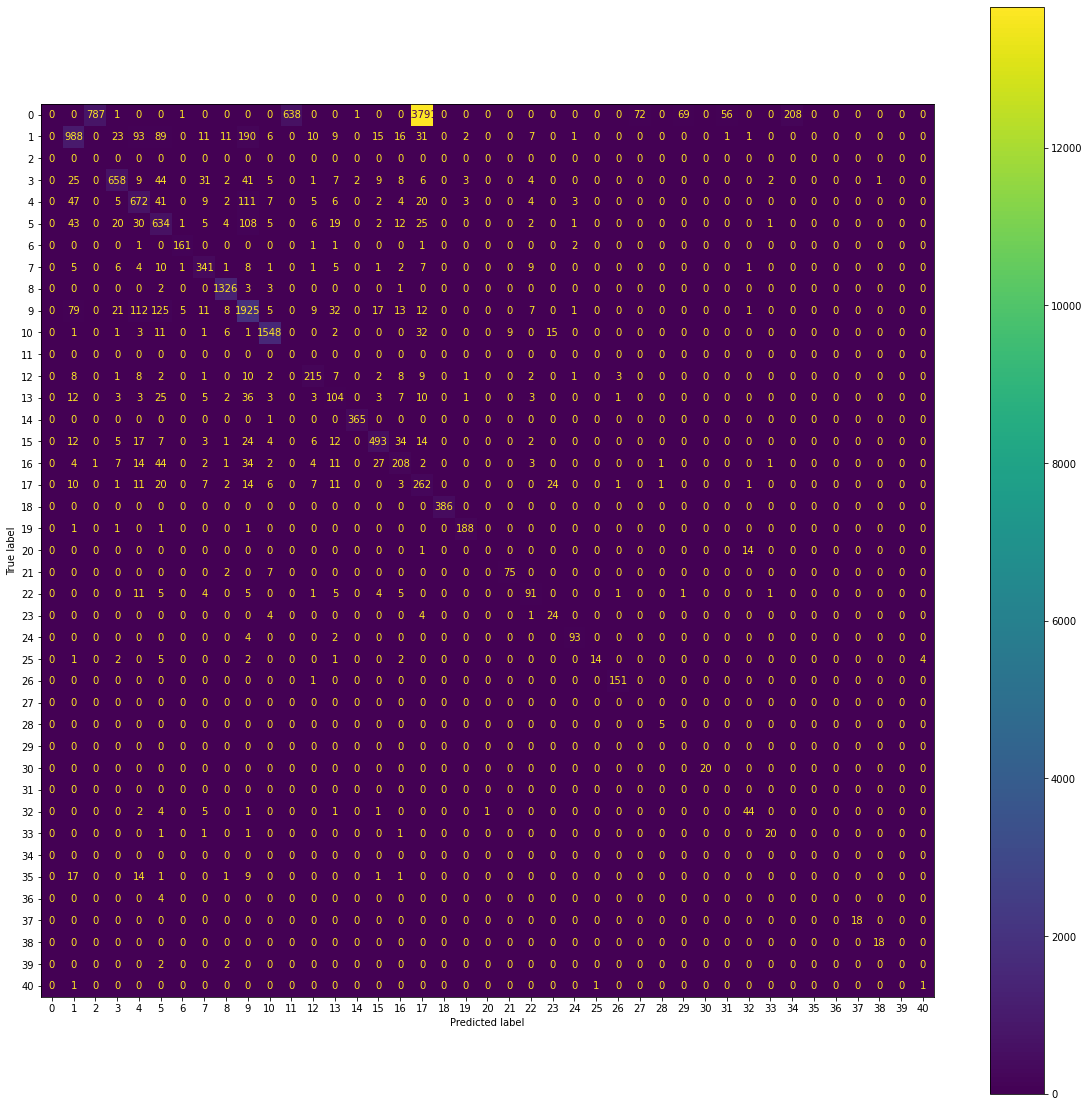

In [ ]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

cm = confusion_matrix(y_list, p_list)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax)

One possible reason can be due to the low number of support for these tags, for example, as can be seen in tags distribution (at the beginning of the report), 'WP$' has extremely low support in the train set. Also, the classification report shows that most of the 'NNPS' tags are classified as 'NNP' which may be due to the spelling or grammatical errors in the dataset. Another one may be related to OOV words. Since we used placeholders (vectors of zeros) for OOV words, the model may struggle for classifying them.

### Finally let's visualize some outputs

In [ ]:
# Batch_size * Num_tags * Seq_len * 1
it = iter(train_dl)
batch = next(it)

# use model with best weights to get output
preds = best_model(batch[0], batch[2]).squeeze(dim = -1)
preds_idx_list = torch.argmax(preds, dim = 1)
preds_idx_list.tolist()[0]


preds_tag = [[ind2tag[ind] for ind in preds_idx] for preds_idx in preds_idx_list.tolist()]
true_tag = [[ind2tag[ind] for ind in preds_idx] for preds_idx in batch[1].tolist()]

pred_df = pd.DataFrame({'Ground Truth': true_tag, 'Prediction': preds_tag})

In [ ]:
pred_df.head()

,Ground Truth,Prediction
0,"[DT, NNP, VBZ, CD, IN, DT, JJ, VBN, NNS, WDT, ...","[DT, NNP, VBZ, CD, IN, DT, JJ, JJ, NNS, WDT, V..."
1,"[DT, NN, RB, MD, VB, DT, WP, VBP, IN, DT, NNP,...","[DT, NN, RB, MD, VB, DT, WP, VBP, IN, DT, NNP,..."
2,"[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
3,"[DT, NN, IN, NN, NN, NNS, IN, DT, NNS, IN, DT,...","[DT, NN, IN, NN, NN, NNS, IN, DT, NNS, IN, DT,..."
4,"[IN, JJ, NNS, VBD, VBN, RBR, IN, DT, NN, IN, ,...","[IN, JJ, NNS, VBD, VBN, RBR, IN, DT, NN, RB, ,..."
